In [63]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
import warnings
import sys
import xgboost as xgb
import optuna
from lazypredict.Supervised import LazyRegressor
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge, RidgeCV, ElasticNetCV, LassoCV, LassoLarsCV, LinearRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.metrics import mean_squared_error
sys.path.append("..") 
%matplotlib inline


#读取数据
train_data = pd.read_csv('./data/train.csv')
test_data = pd.read_csv('./data/test.csv')
combined_df = pd.concat([train_data,test_data],axis=0)
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.00,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.00,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.00,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.00,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.00,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [64]:
#训练数据大小
train_data.shape

(1460, 81)

In [65]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [66]:
#训练数据类型统计
train_dtype = train_data.dtypes
train_dtype.value_counts()

object     43
int64      35
float64     3
dtype: int64

In [67]:
#训练数据信息
train_data.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.00,1460.00,1201.00,1460.00,1460.00,1460.00,1460.00,1460.00,1452.00,1460.00,...,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00
mean,730.50,56.90,70.05,10516.83,6.10,5.58,1971.27,1984.87,103.69,443.64,...,94.24,46.66,21.95,3.41,15.06,2.76,43.49,6.32,2007.82,180921.20
std,421.61,42.30,24.28,9981.26,1.38,1.11,30.20,20.65,181.07,456.10,...,125.34,66.26,61.12,29.32,55.76,40.18,496.12,2.70,1.33,79442.50
min,1.00,20.00,21.00,1300.00,1.00,1.00,1872.00,1950.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,2006.00,34900.00
25%,365.75,20.00,59.00,7553.50,5.00,5.00,1954.00,1967.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.00,2007.00,129975.00
50%,730.50,50.00,69.00,9478.50,6.00,5.00,1973.00,1994.00,0.00,383.50,...,0.00,25.00,0.00,0.00,0.00,0.00,0.00,6.00,2008.00,163000.00
75%,1095.25,70.00,80.00,11601.50,7.00,6.00,2000.00,2004.00,166.00,712.25,...,168.00,68.00,0.00,0.00,0.00,0.00,0.00,8.00,2009.00,214000.00
max,1460.00,190.00,313.00,215245.00,10.00,9.00,2010.00,2010.00,1600.00,5644.00,...,857.00,547.00,552.00,508.00,480.00,738.00,15500.00,12.00,2010.00,755000.00


In [68]:
#训练数据中的空值排序前20个
train_data.isnull().sum().sort_values(ascending=False).head(20)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageCond        81
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
Utilities          0
dtype: int64

<AxesSubplot:>

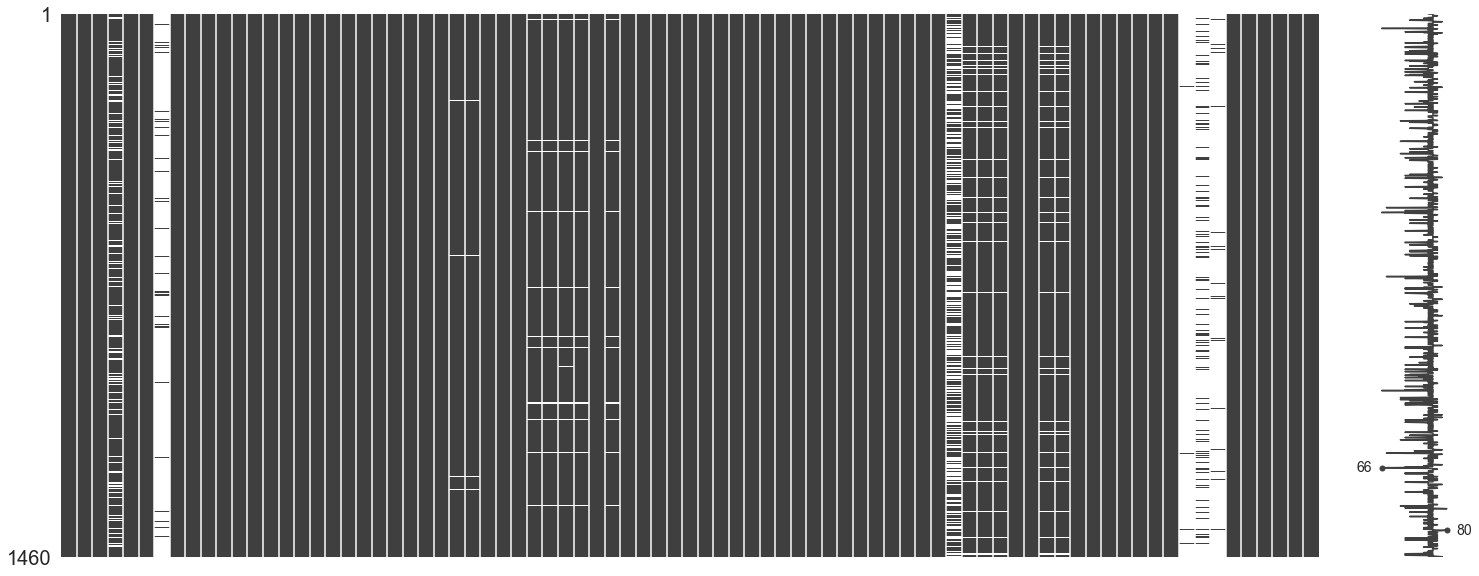

In [69]:
#可视化缺省值
msno.matrix(train_data)

<AxesSubplot:>

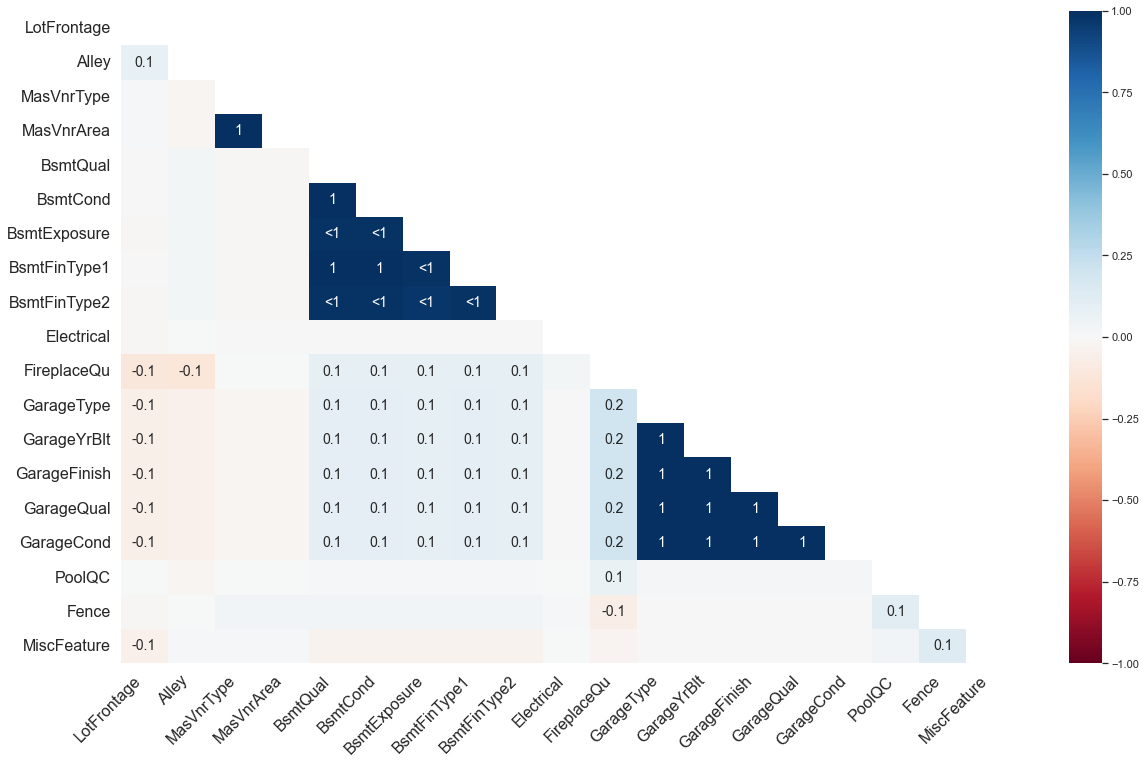

In [70]:
# 使用misingno查看缺失数据之间的相关性：表征一个变量的存在和不存在如何强烈地影响另一个的存在
# （比如说如果rate1和rate2的热度值是1,那么rate11缺失，rate2也必然缺失，两者在缺失性之间是直接相关的）
msno.heatmap(train_data)

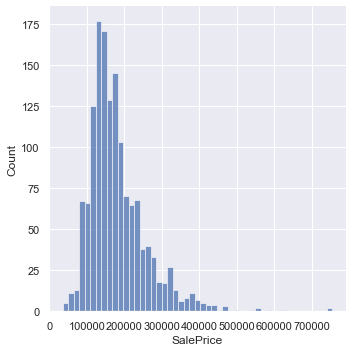

In [71]:
# 查看训练数据对应价格的分布
sns.displot(train_data['SalePrice'])

<AxesSubplot:xlabel='OverallQual', ylabel='SalePrice'>

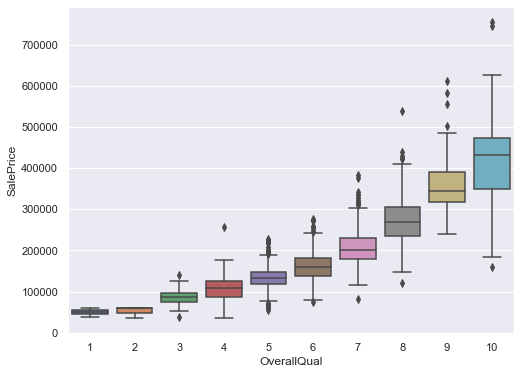

In [72]:
# 可以看到整体评分越高其价格是越高的
overallQual_SalePrice = pd.concat([train_data['SalePrice'],train_data['OverallQual']],axis=1)
plt.figure(figsize=(8,6))
sns.boxplot(x='OverallQual',y='SalePrice',data=overallQual_SalePrice)

<AxesSubplot:xlabel='Neighborhood', ylabel='SalePrice'>

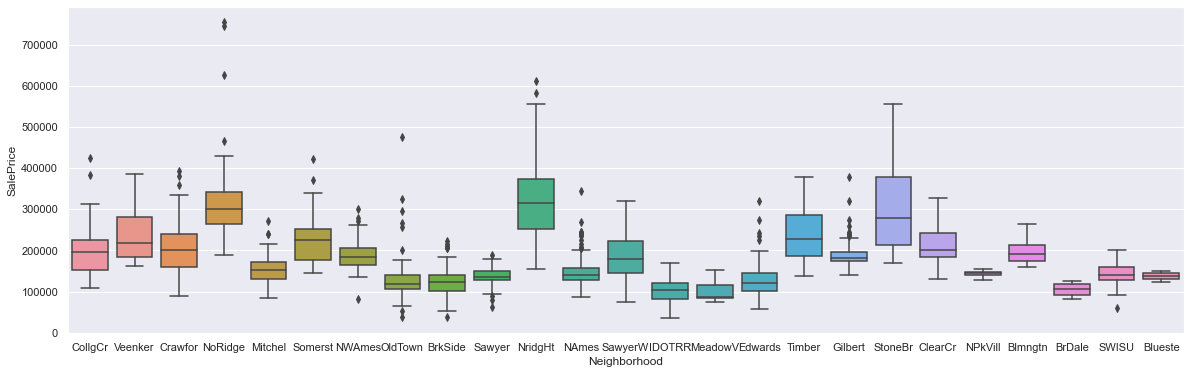

In [73]:
# 用箱状图查看一下离散非数值型数据的分布
# 可以看到如果neighorhood是在stoneBr和NridgHt附近的话，价格会较高
Neighborhood_SalePrice = pd.concat([train_data['SalePrice'],train_data['Neighborhood']],axis=1)
plt.figure(figsize=(20,6))
sns.boxplot(x='Neighborhood',y='SalePrice',data=Neighborhood_SalePrice)

<AxesSubplot:xlabel='TotalBsmtSF', ylabel='SalePrice'>

<Figure size 576x432 with 0 Axes>

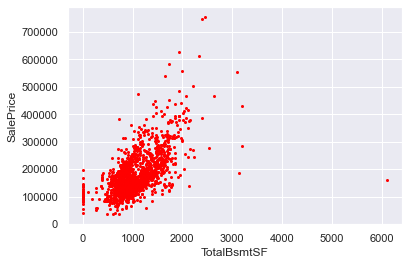

In [74]:
# 绘制和价格相关的特征的散点图
TotalBsmtSF_SalePrice = pd.concat([train_data['SalePrice'],train_data['TotalBsmtSF']],axis=1)
plt.figure(figsize=(8,6))
TotalBsmtSF_SalePrice.plot.scatter(x='TotalBsmtSF',y='SalePrice',s=4,c='red')

In [75]:
test_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.00,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.00,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.00,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.00,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.00,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [76]:
# 查看测试数据中的数据类型统计
test_dtype = test_data.dtypes
test_dtype.value_counts()

object     43
int64      26
float64    11
dtype: int64

In [77]:
#测试数据集的数据大小
test_data.shape

(1459, 80)

In [78]:
#测试数据集缺省值前20
test_data.isnull().sum().sort_values(ascending = False).head(20)

PoolQC          1456
MiscFeature     1408
Alley           1352
Fence           1169
FireplaceQu      730
LotFrontage      227
GarageCond        78
GarageQual        78
GarageYrBlt       78
GarageFinish      78
GarageType        76
BsmtCond          45
BsmtQual          44
BsmtExposure      44
BsmtFinType1      42
BsmtFinType2      42
MasVnrType        16
MasVnrArea        15
MSZoning           4
BsmtHalfBath       2
dtype: int64

<AxesSubplot:>

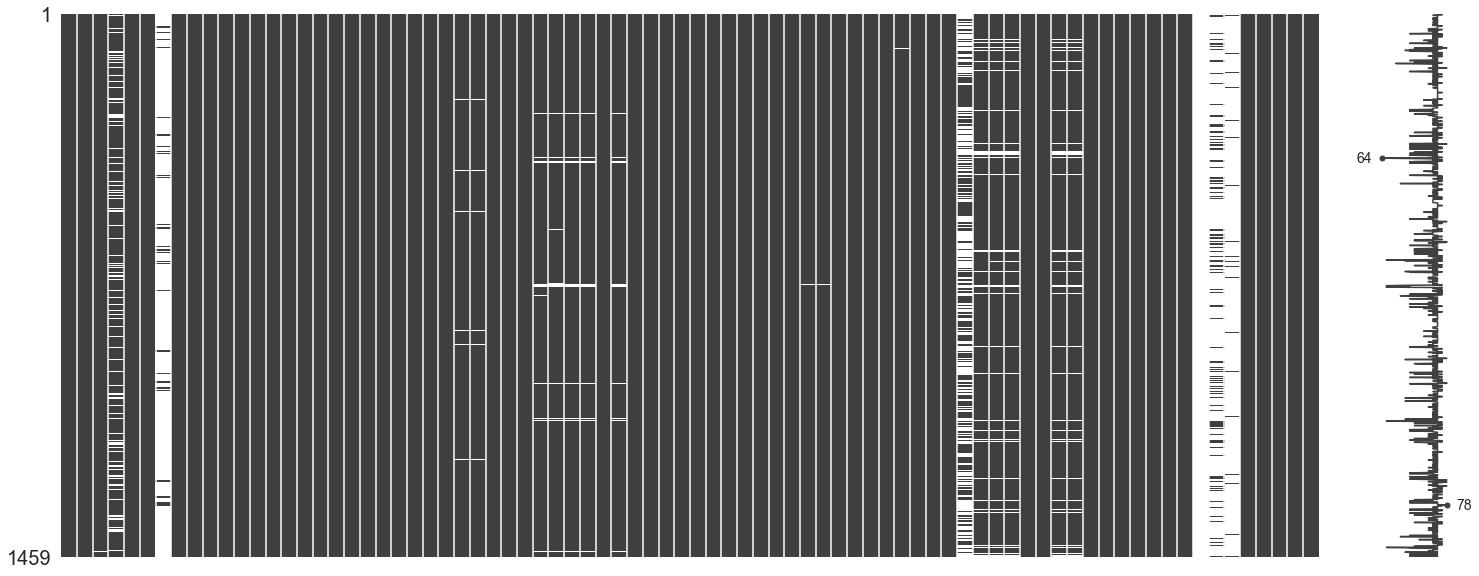

In [79]:
#缺失数据可视化
msno.matrix(test_data)

<AxesSubplot:>

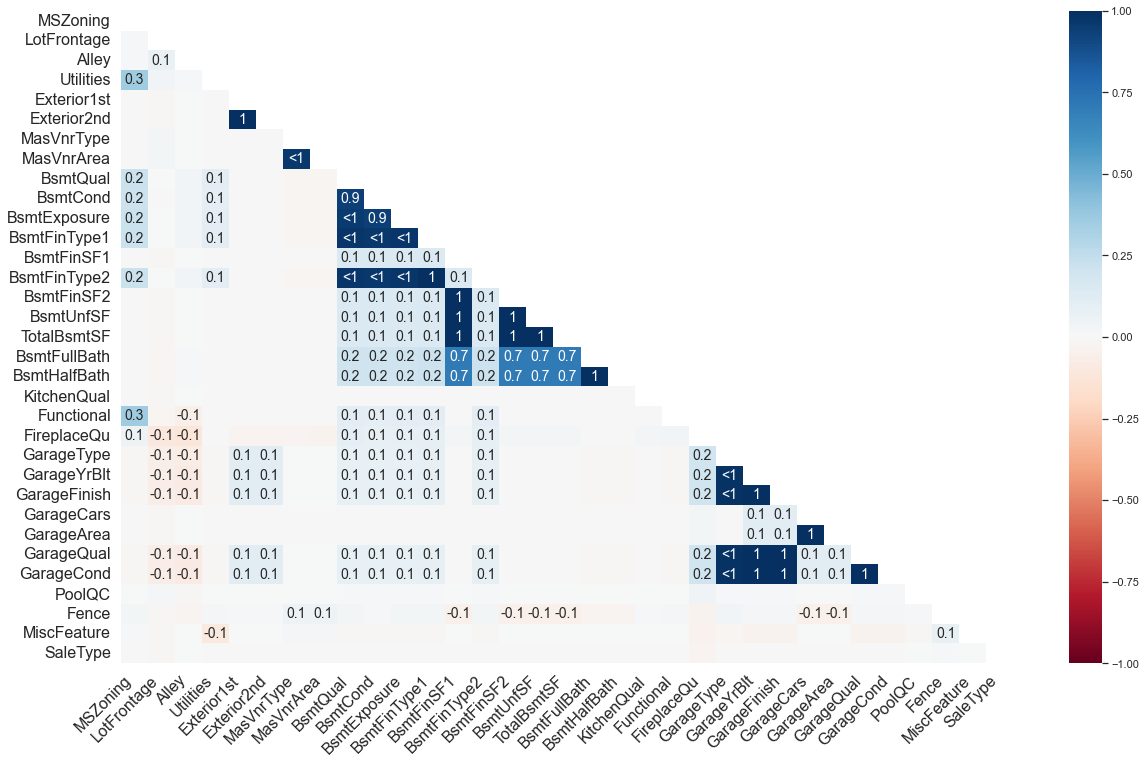

In [80]:
# 缺省值对比分析，可看出测试数据缺失比训练数据更严重
msno.heatmap(test_data)

In [81]:
# 将标签值SalePrice去除，然后使用pandas的compare将两个dataframe进行比较
train_dtype = train_dtype.drop('SalePrice')
train_dtype.compare(test_dtype)

AttributeError: 'Series' object has no attribute 'compare'

In [82]:
#缺失数据对比
null_train = train_data.isnull().sum()
null_test = test_data.isnull().sum()
null_train = null_train.drop('SalePrice')
null_comp_df = null_train.compare(null_test).sort_values(['self'],ascending=[False])
null_comp_df

AttributeError: 'Series' object has no attribute 'compare'

In [83]:
numerical_features = [col for col in train_data.columns if train_data[col].dtypes != 'O']
discrete_features = [col for col in numerical_features if len(train_data[col].unique()) < 25 and col not in ['Id']]
continuous_features = [feature for feature in numerical_features if feature not in discrete_features+['Id']]
categorical_features = [col for col in train_data.columns if train_data[col].dtype == 'O']

print("Total Number of Numerical Columns : ",len(numerical_features))
print("Number of discrete features : ",len(discrete_features))
print("No of continuous features are : ", len(continuous_features))
print("Number of non-numeric features : ",len(categorical_features))

Total Number of Numerical Columns :  38
Number of discrete features :  18
No of continuous features are :  19
Number of non-numeric features :  43


In [84]:
#打标签标识训练数据和测试数据
combined_df['Label'] = "test"
combined_df['Label'][:1460] = "Train"

ValueError: cannot reindex from a duplicate axis

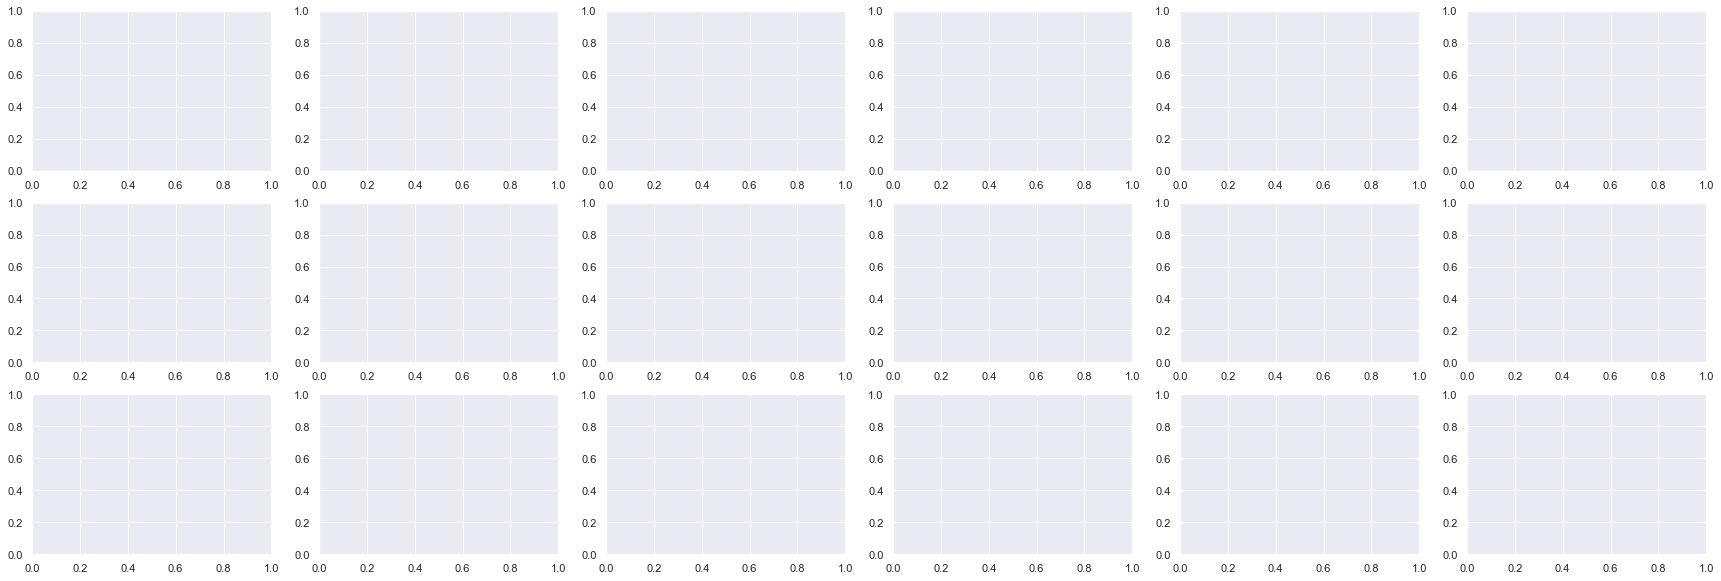

In [85]:
# 对比离散数据
"""
sns.hitplot(data,x,y,hue,ax)
data:pandas.Dataframe,numpy.ndarray,mapping,or sequence：input data
x,y : 指定x,y轴的变量
hue：确定绘图颜色的变量
ax:预先定义的绘图区域
"""
f,axes = plt.subplots(3,6,figsize=(30,10),sharex=False)
for i,feature in enumerate(discrete_features):
    sns.histplot(data=combined_df,x=feature,hue='Label',ax=axes[i%3,i//3])

ValueError: cannot reindex from a duplicate axis

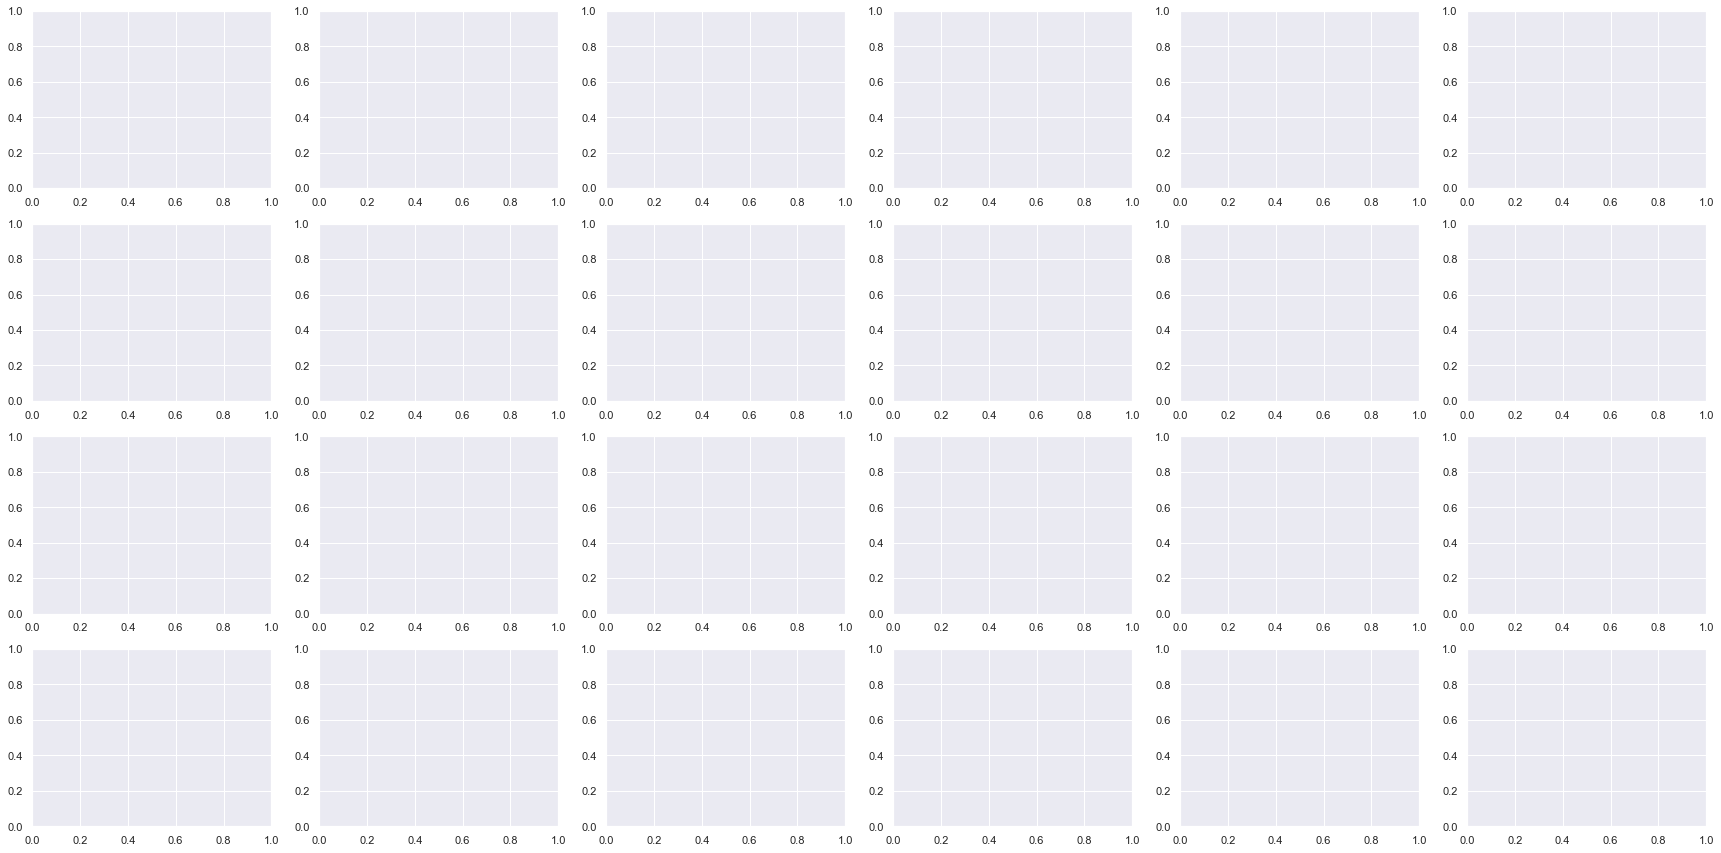

In [86]:
#对比连续数据
f,axes = plt.subplots(4,6,figsize=(30,15),sharex=False)
for i,feature in enumerate(continuous_features):
    sns.histplot(data=combined_df,x=feature,hue='Label',ax=axes[i%4,i//4])

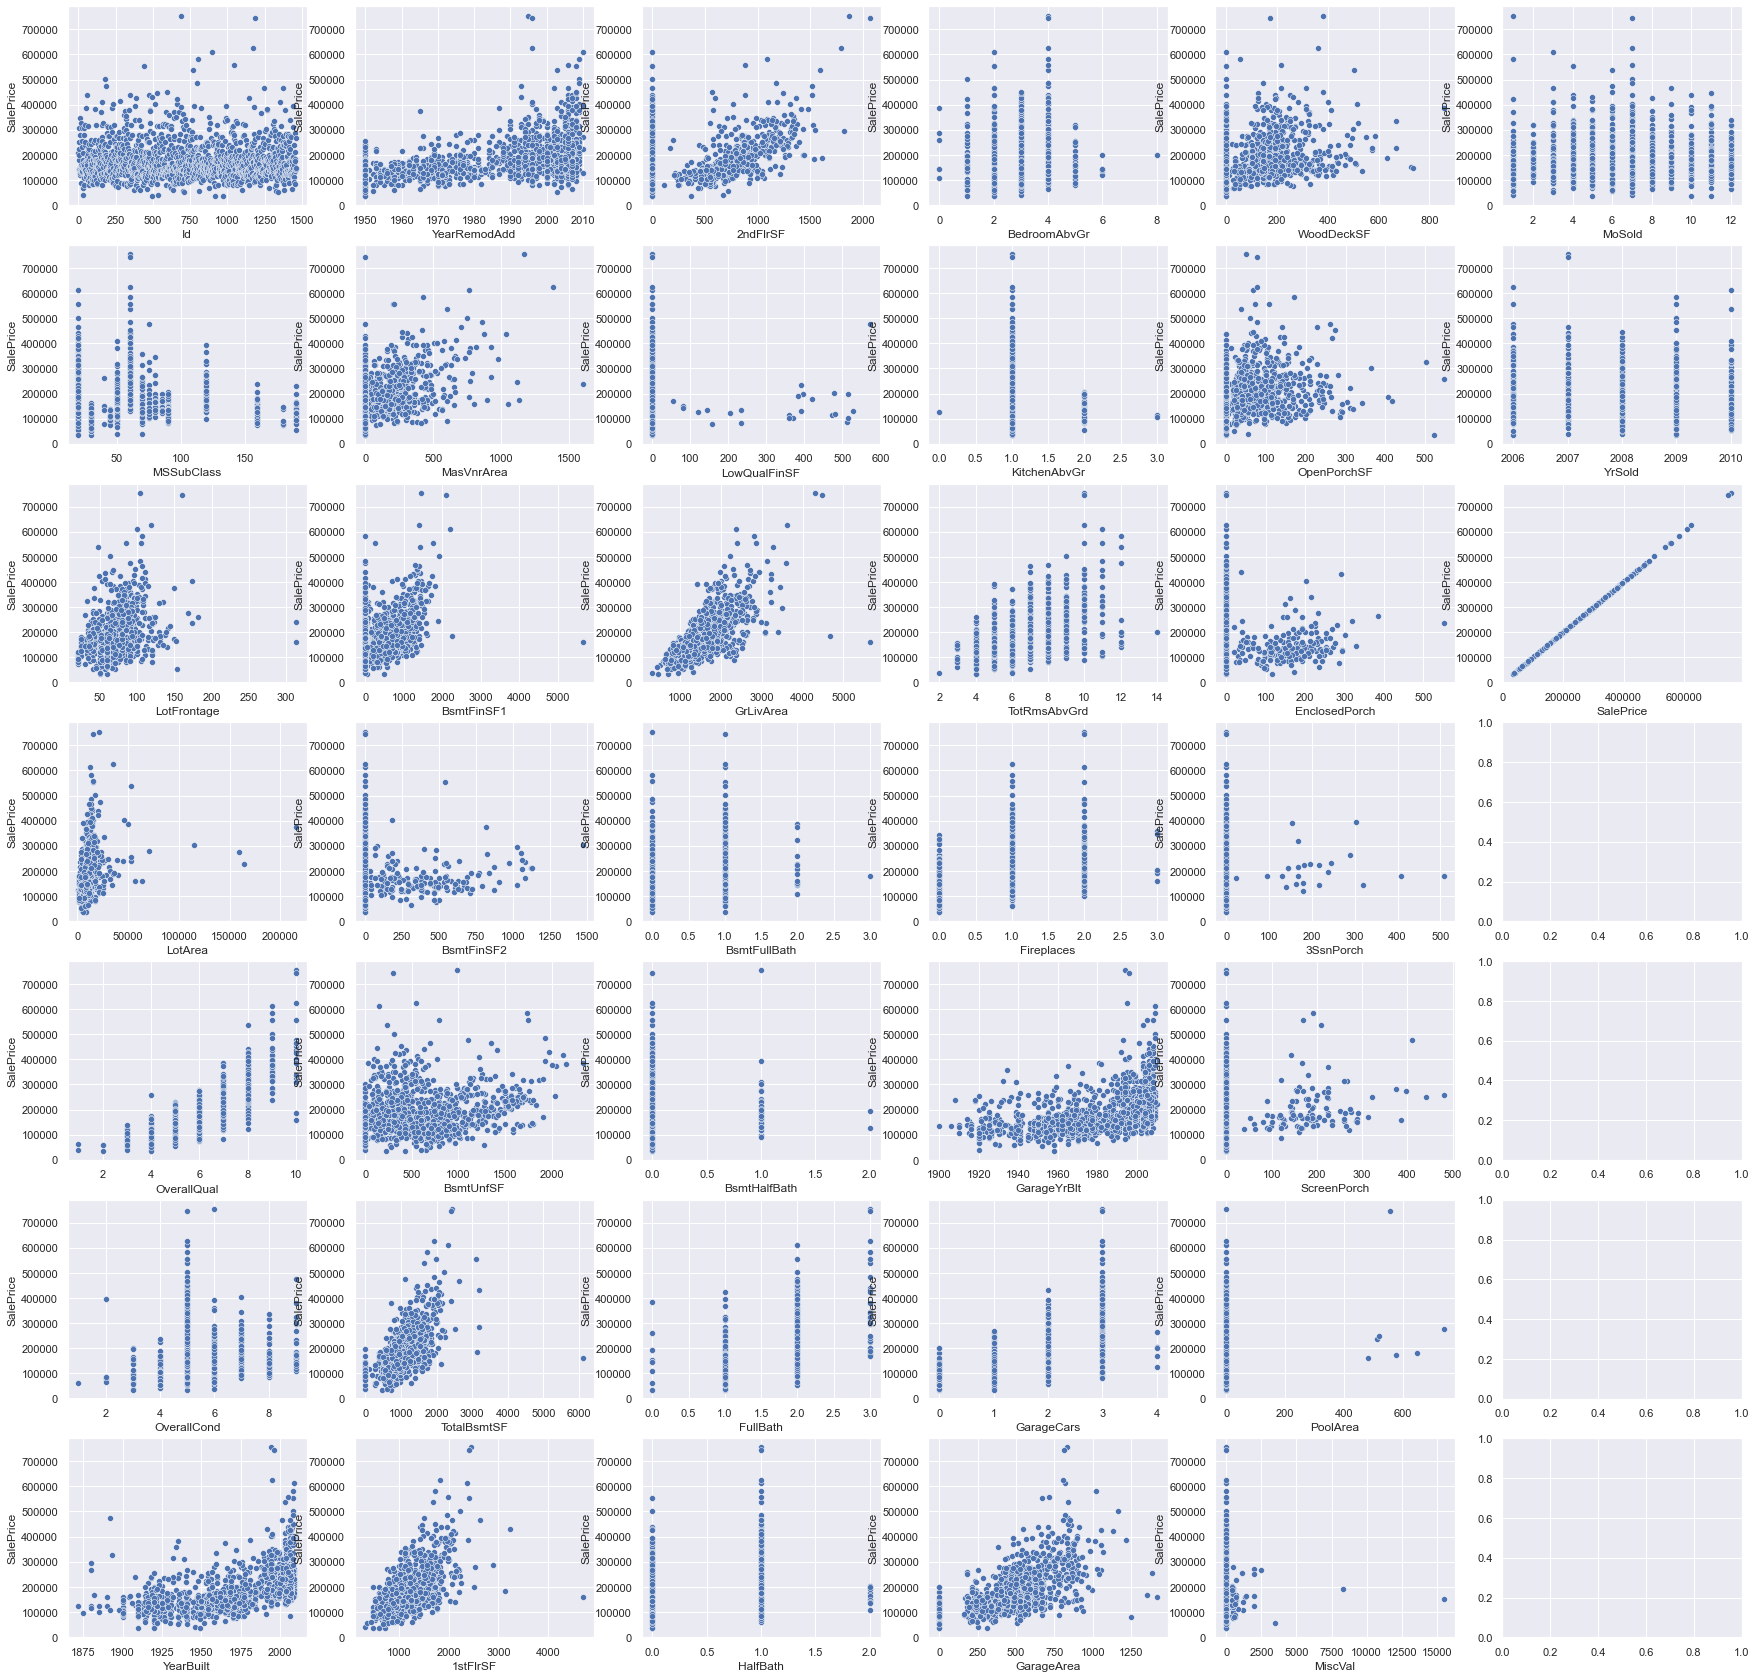

In [87]:
# 检查数值数据的线性分布
"""
横轴为数值数据特征，纵轴为价格标签
"""
f,axes = plt.subplots(7,6,figsize=(30,30),sharex=False)
for i,feature in enumerate(numerical_features):
    sns.scatterplot(data=combined_df,x=feature,y="SalePrice",ax=axes[i%7,i//7])

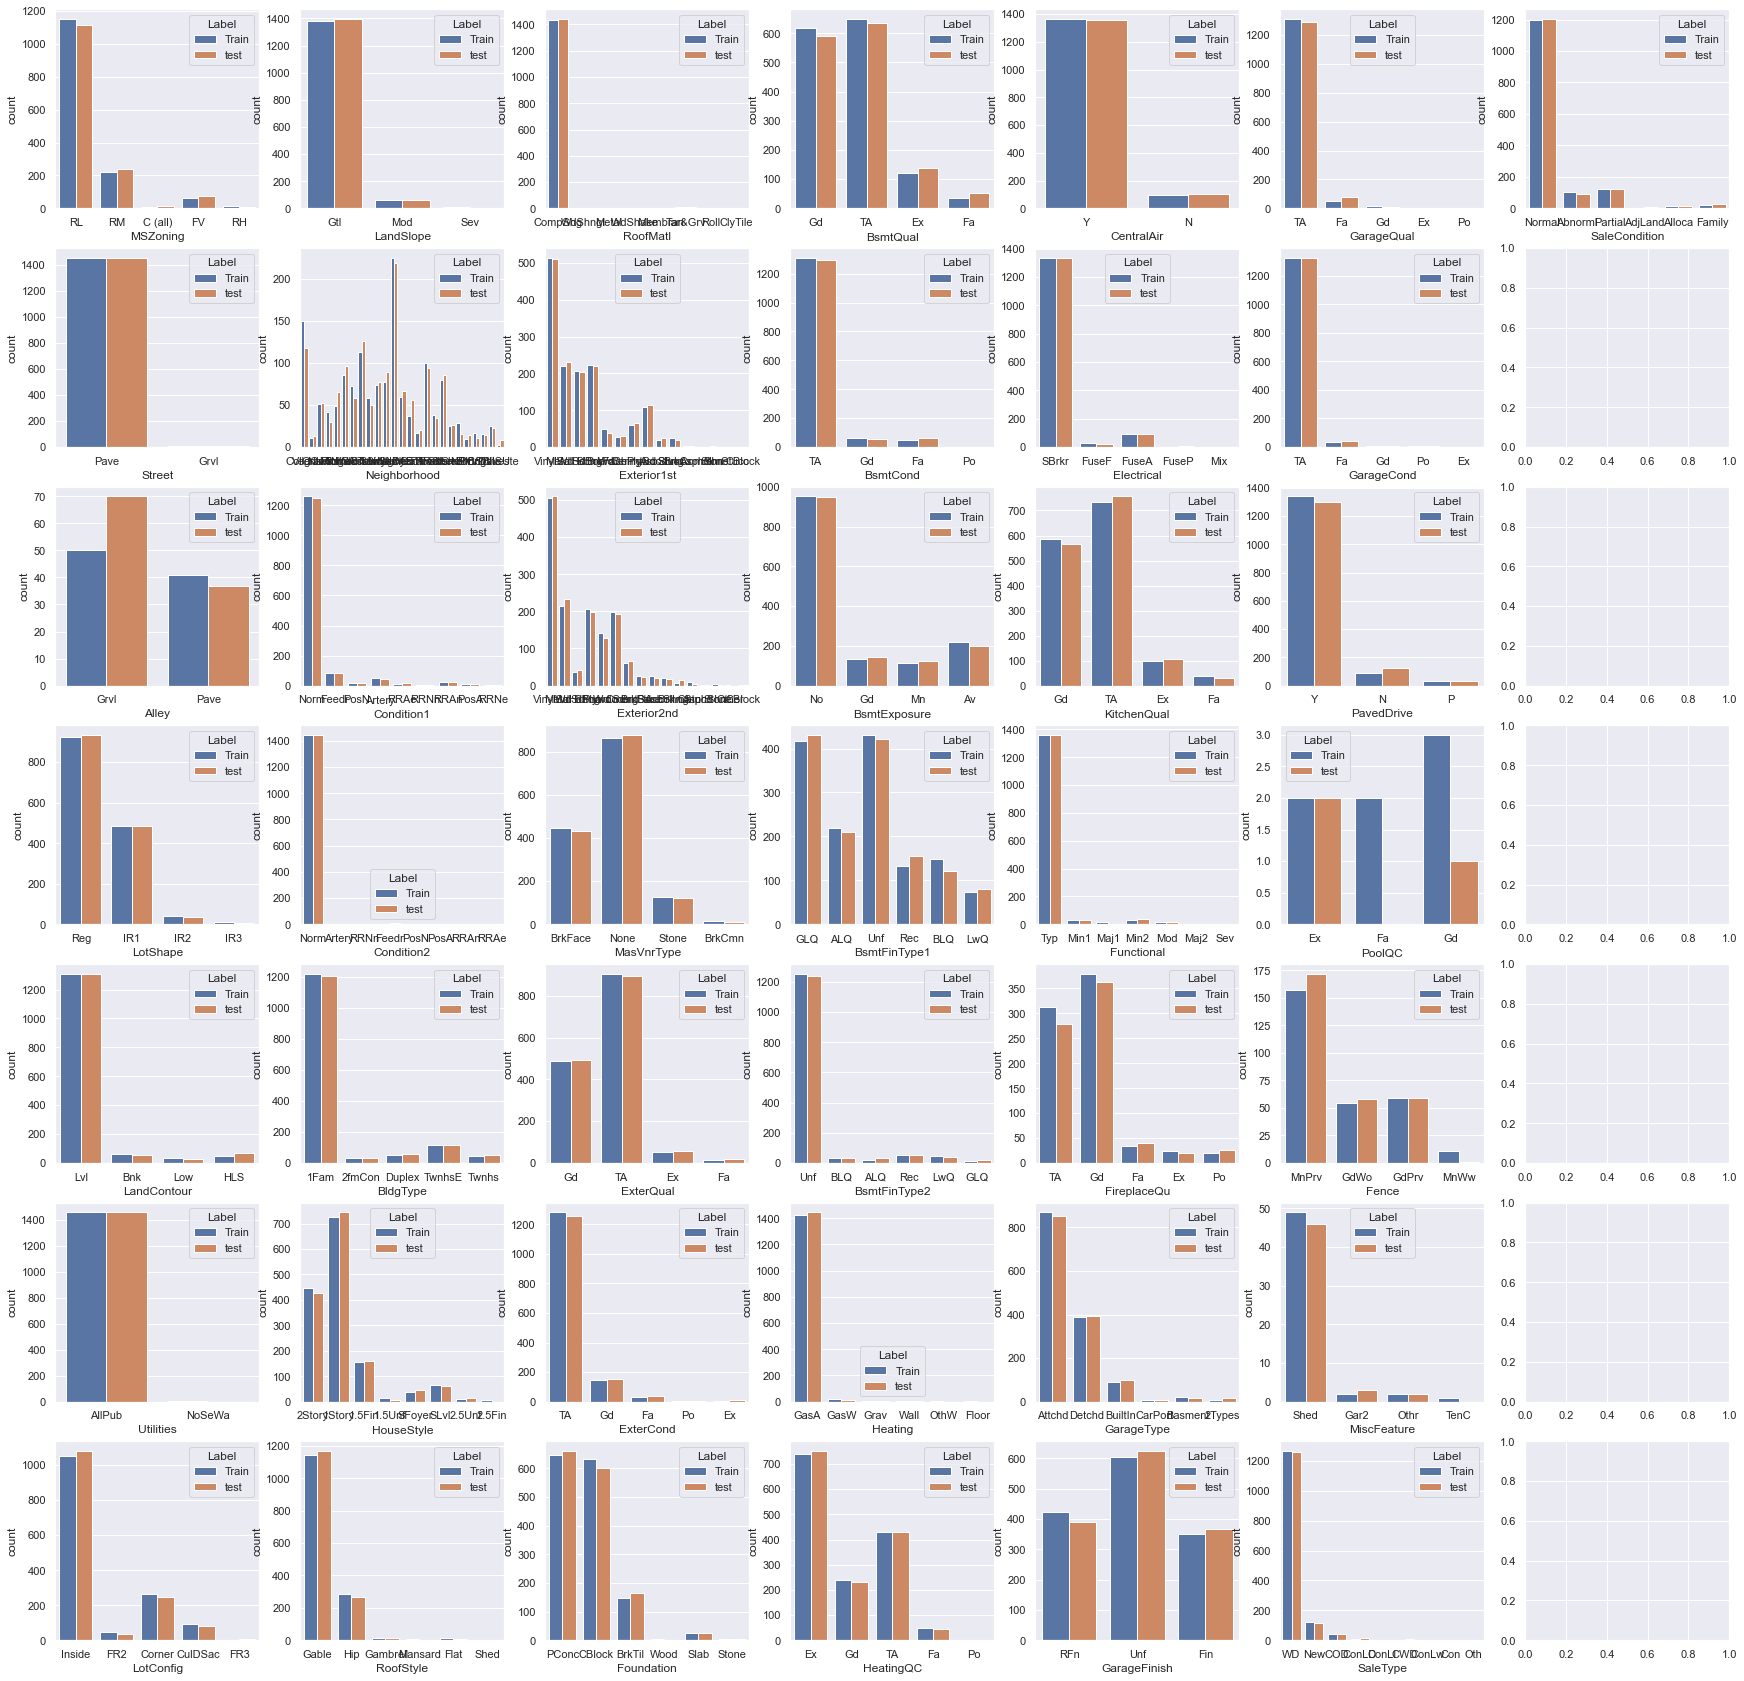

In [88]:
# 对比非数值型数据对比分析
f,axes = plt.subplots(7,7,figsize=(30,30),sharex=False)
for i,feature in enumerate(categorical_features):
    sns.countplot(data=combined_df,x=feature,hue="Label",ax=axes[i%7,i//7])

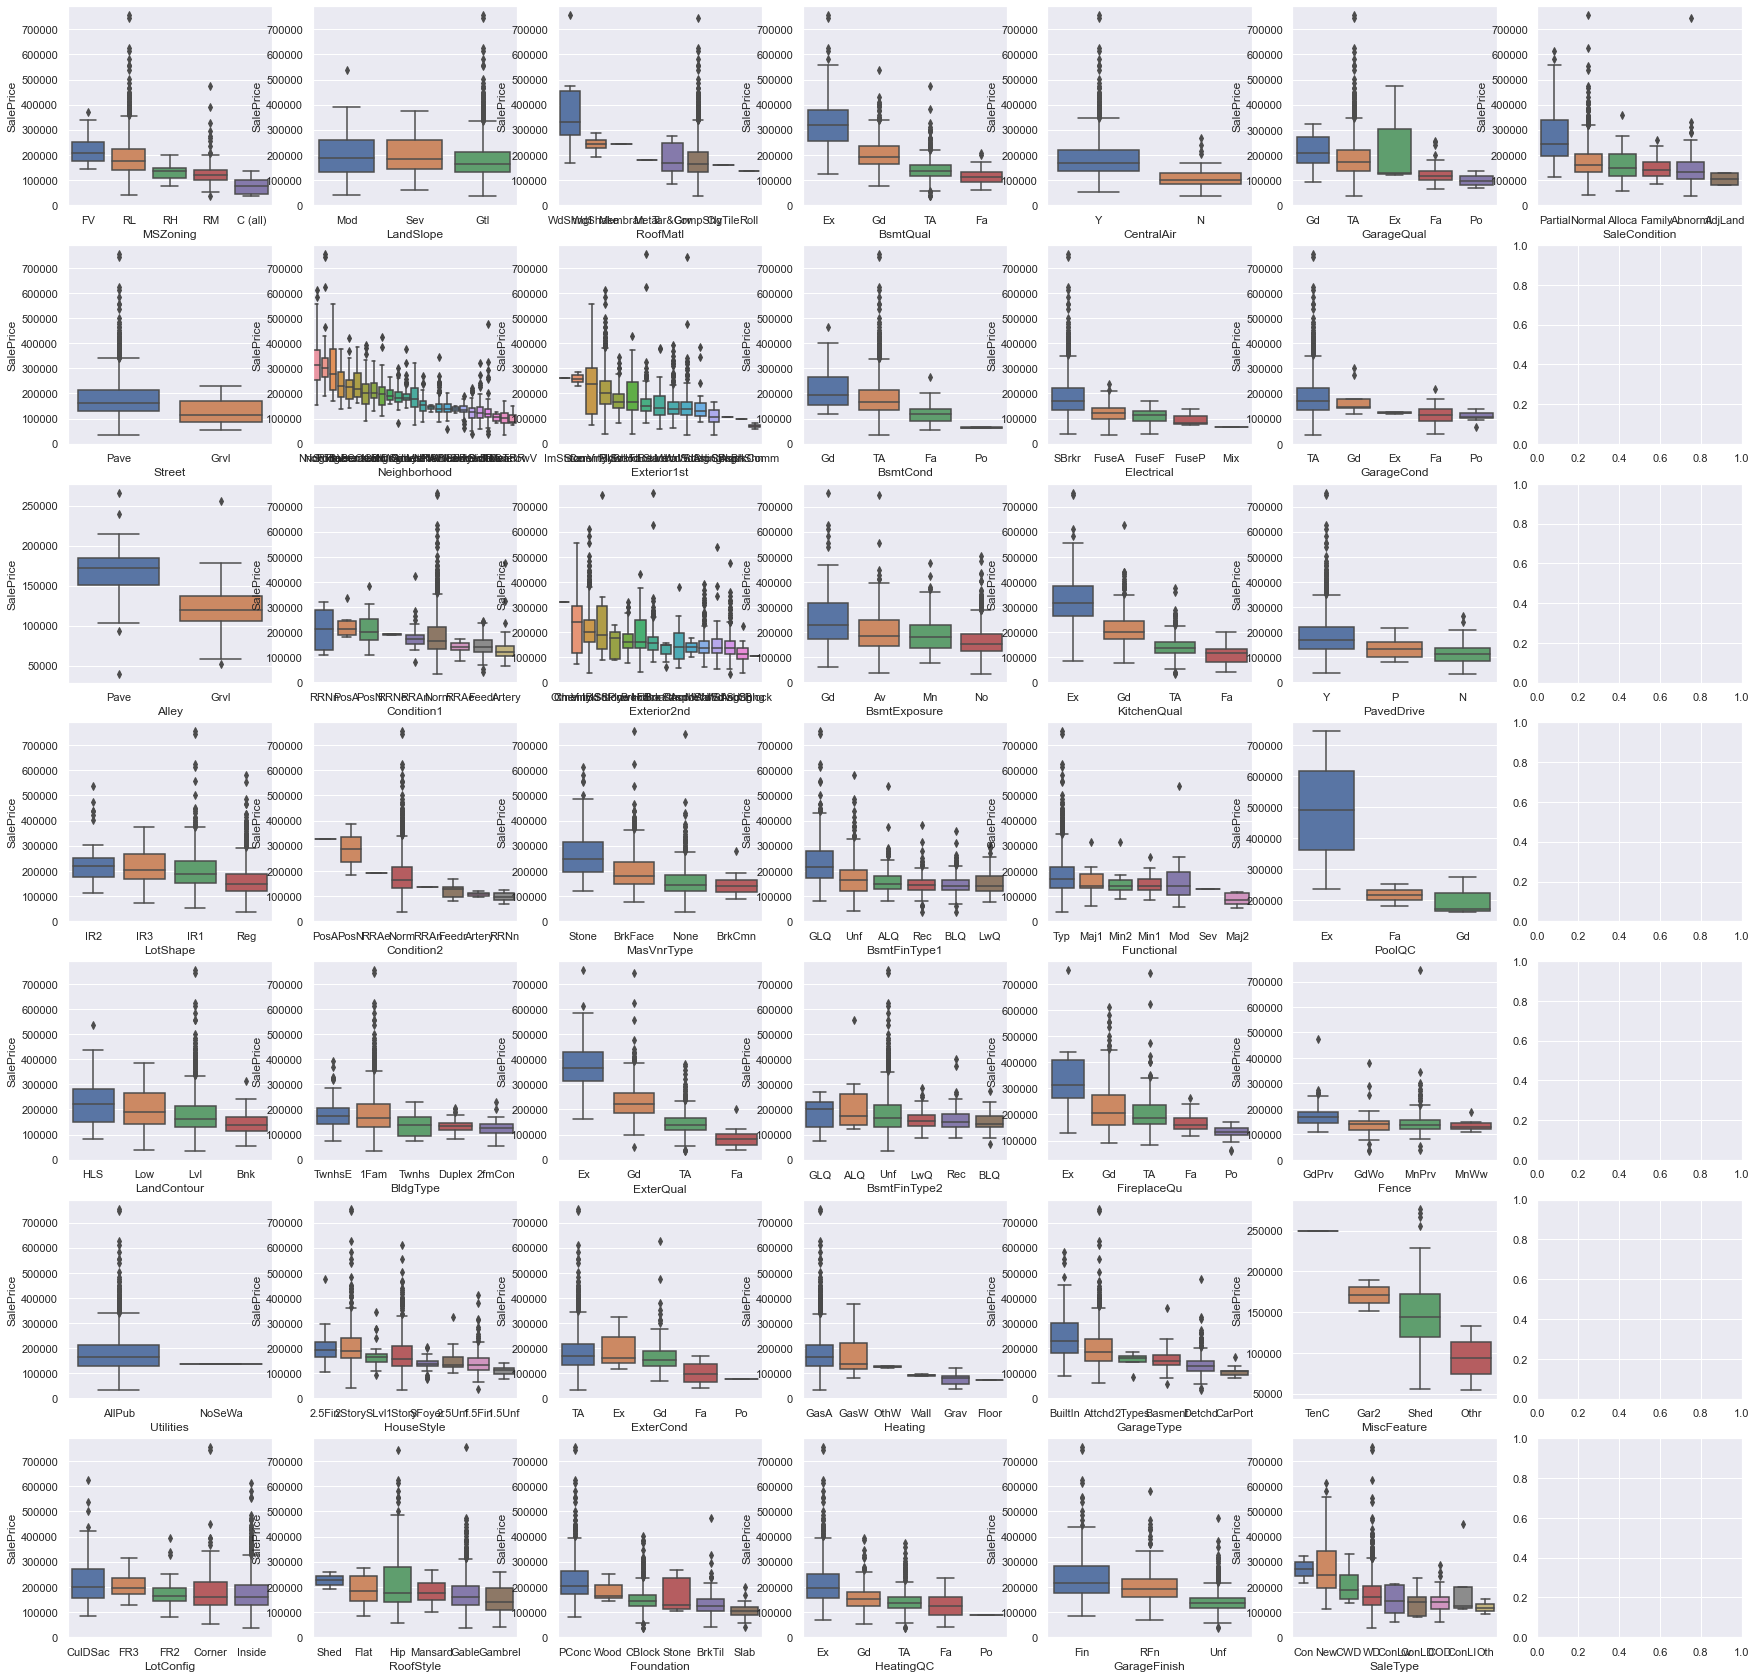

In [89]:
# 通过箱状图分析非数值型数据的分布（值取的对应价格）
f, axes = plt.subplots(7,7 , figsize=(30, 30), sharex=False)
for i, feature in enumerate(categorical_features):
    sort_list = sorted(combined_df.groupby(feature)['SalePrice'].median().items(), key= lambda x:x[1], reverse = True)
    order_list = [x[0] for x in sort_list ]
    sns.boxplot(data = combined_df, x = feature, y = 'SalePrice', order=order_list, ax=axes[i%7, i//7])
plt.show()

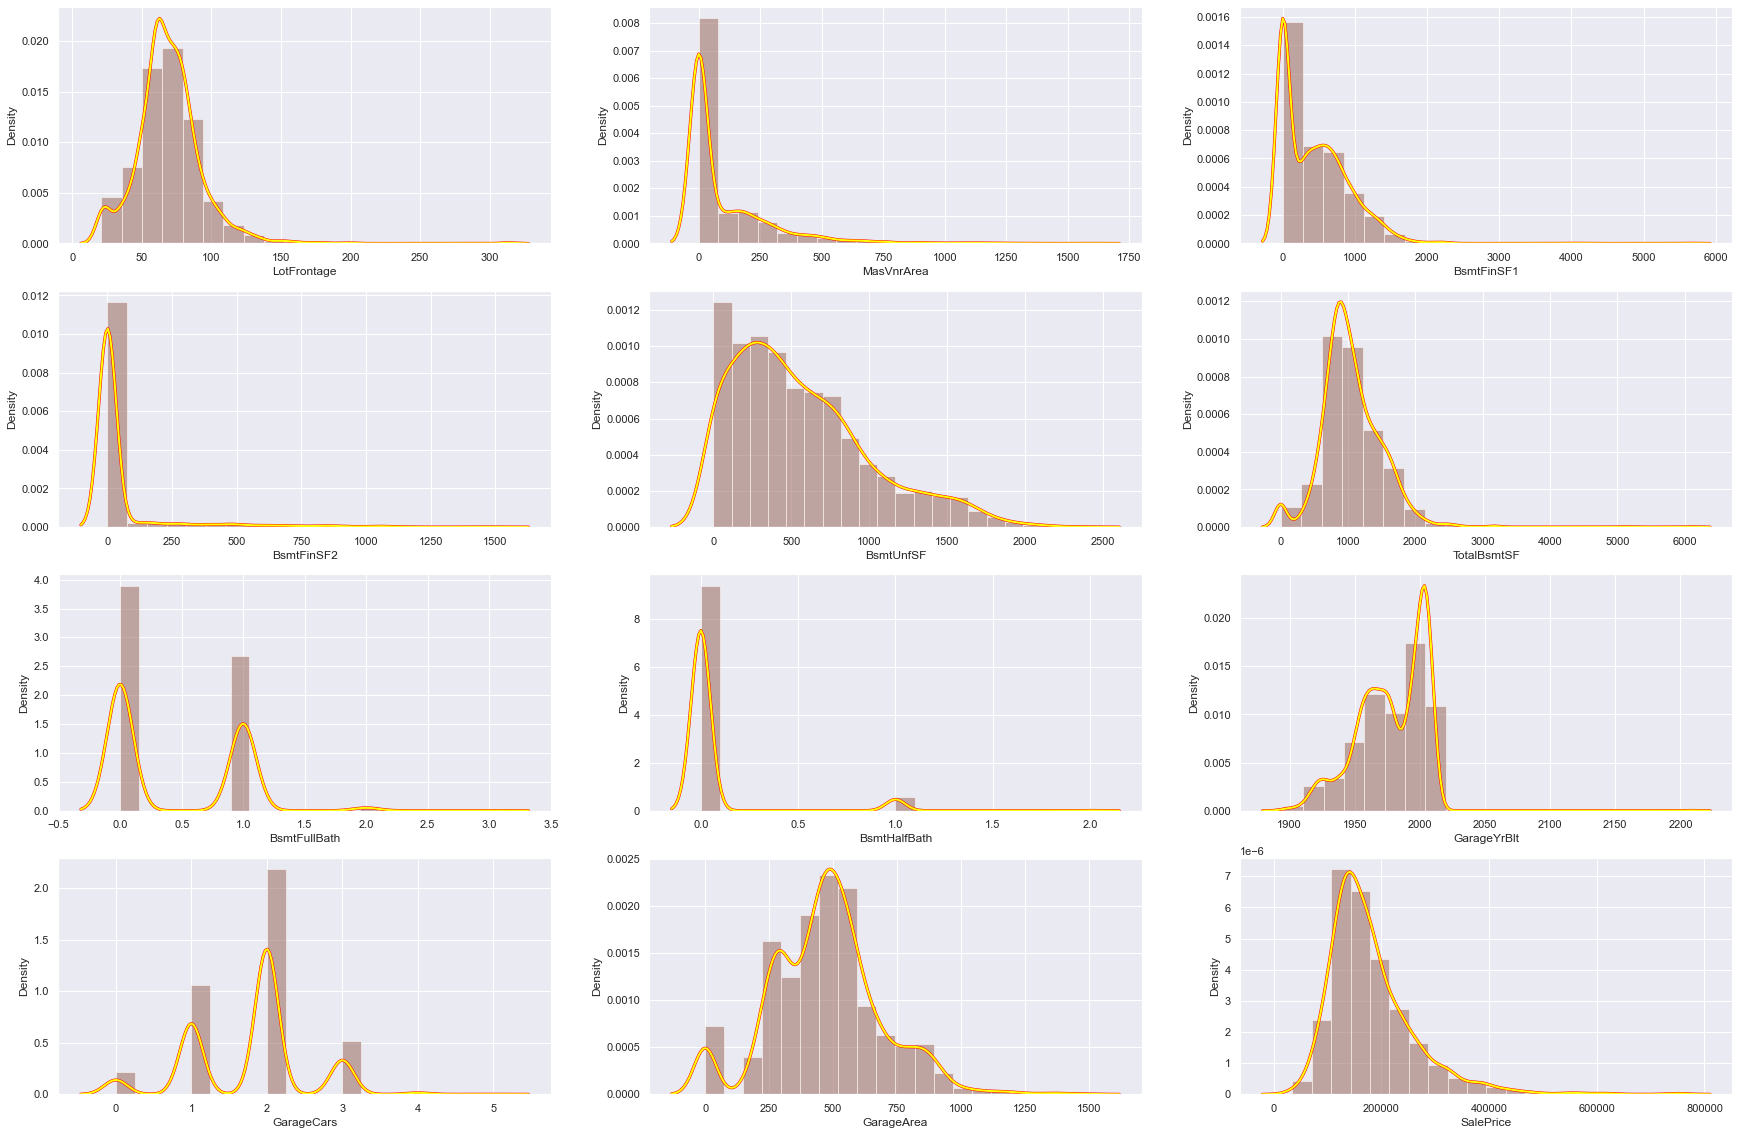

In [90]:
# 检查数值型数据的分布特征并填充均值
null_features_numerical = [col for col in combined_df.columns if combined_df[col].isnull().sum()>0 and col not in categorical_features]
plt.figure(figsize=(30,20))
sns.set()

warnings.simplefilter('ignore')
for i,var in enumerate(null_features_numerical):
    plt.subplot(4,3,i+1)
    sns.distplot(combined_df[var],bins=20,kde_kws={'linewidth':3,'color':'red'},label="original")
    sns.distplot(combined_df[var],bins=20,kde_kws={'linewidth':2,'color':'yellow'},label="mean")

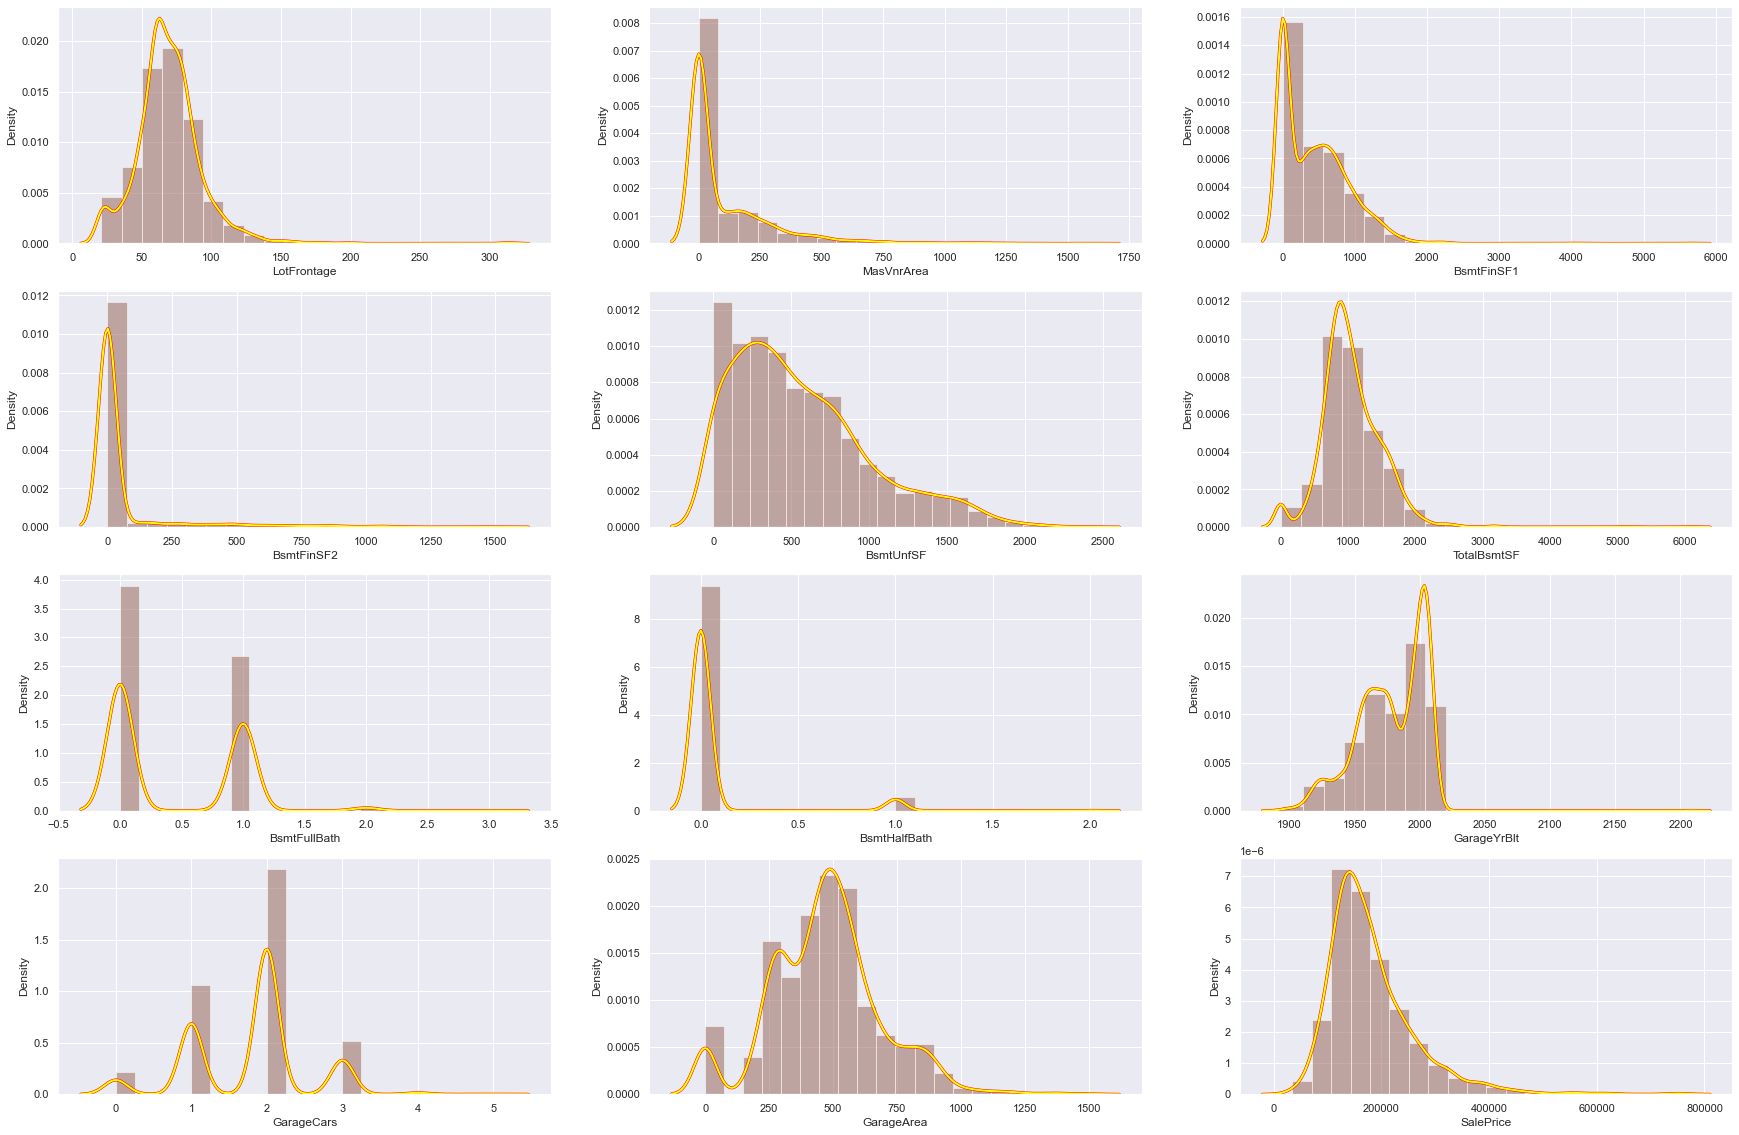

In [91]:
# # 检查数值型数据的分布特征并填充中位值
plt.figure(figsize=(30,20))
sns.set()
warnings.simplefilter("ignore")
for i,var in enumerate(null_features_numerical):
    plt.subplot(4,3,i+1)
    sns.distplot(combined_df[var],bins=20,kde_kws={'linewidth':3,'color':'red'},label="original")
    sns.distplot(combined_df[var],bins=20,kde_kws={'linewidth':2,'color':'yellow'},label="median")

In [92]:
year_feature = [col for col in combined_df.columns if "Yr" in col or 'Year' in col]
year_feature

['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold']

Text(0.5, 1.0, 'House price vs YearSold')

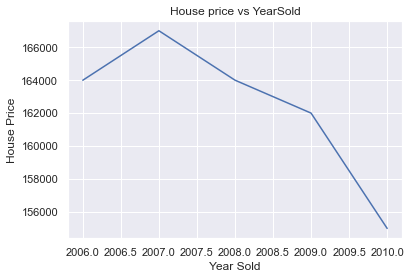

In [93]:
# 然后检查一下这些特征与销售价格是否有关系
combined_df.groupby('YrSold')['SalePrice'].median().plot() # groupby().median()表示取每一组的中位数
plt.xlabel('Year Sold')
plt.ylabel('House Price')
plt.title('House price vs YearSold')

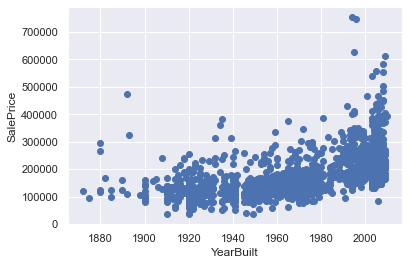

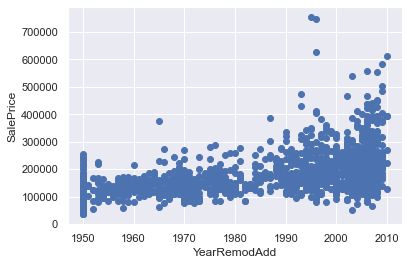

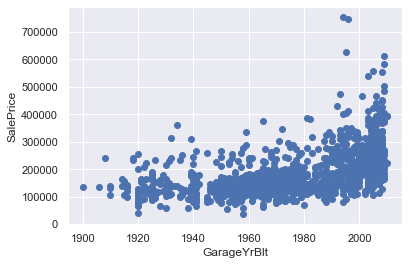

In [94]:
# 绘制其他三个特征与销售价格的散点对应图
# 可以看到随着时间的增加，价格是逐增加的
for feature in year_feature:
    if feature != 'YrSold':
        hs = combined_df.copy()
        plt.scatter(hs[feature],hs['SalePrice'])
        plt.xlabel(feature)
        plt.ylabel('SalePrice')
        plt.show()

<AxesSubplot:>

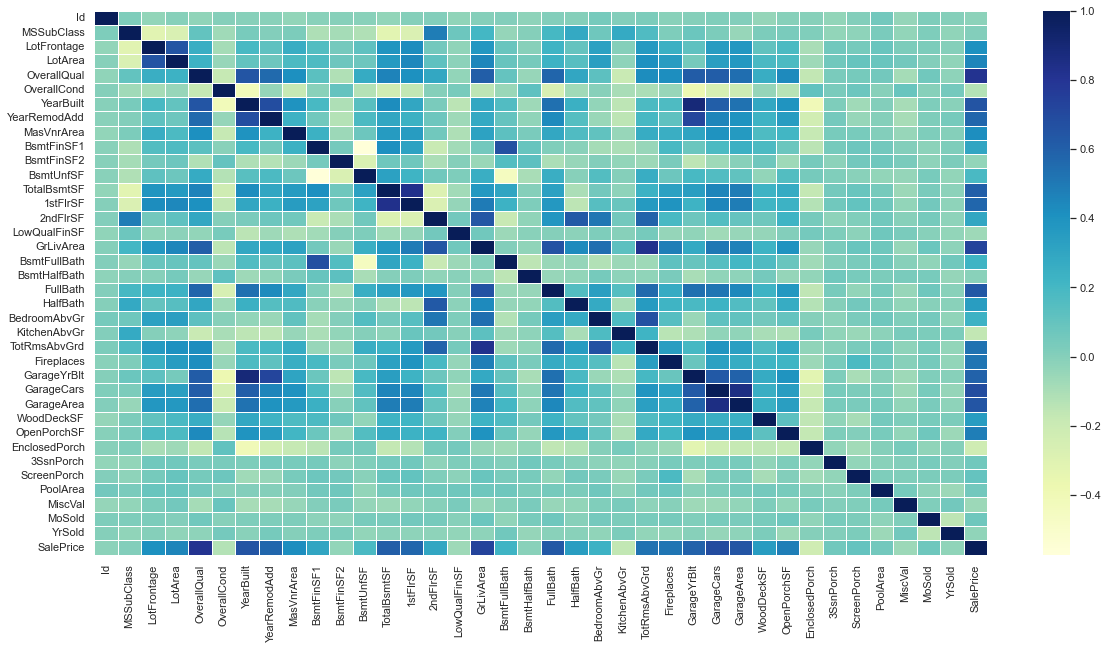

In [95]:
# 使用热力图查看特征之间的相互关系
corrmat = train_data.corr(method='spearman') # 计算不同数据之间的相系数
plt.figure(figsize=(20,10))
sns.heatmap(corrmat,cmap="YlGnBu", linewidths=.5)

In [96]:
# id不是特征，将id去除,同时将训练数据和测试数据放在仪器做预处理
# Label是上面为了区别训练数据和测试数据加入的一个特征，实际训练也不需要，需要去除
# 如Alley、fence等特征属于上面数据缺失过多或者主要是0/null的情况
drop_columns = ["Id", "Alley", "Fence", "LotFrontage", "FireplaceQu", "PoolArea", "LowQualFinSF", "3SsnPorch", "MiscVal", 'RoofMatl','Street','Condition2','Utilities','Heating','Label']
print("Number of columns before dropping : ",len(combined_df.columns))
print("Number of dropping columns : ",len(drop_columns))
combined_df.drop(columns=drop_columns, inplace=True, errors='ignore')
print("Number of columns after dropping : ",len(combined_df.columns))

Number of columns before dropping :  82
Number of dropping columns :  15
Number of columns after dropping :  67


In [97]:
for feature in ['YearBuilt','YearRemodAdd','GarageYrBlt']:
    combined_df[feature]=combined_df['YrSold']-combined_df[feature]
combined_df[['YearBuilt','YearRemodAdd','GarageYrBlt']].head()

,YearBuilt,YearRemodAdd,GarageYrBlt
0,5,5,5.00
1,31,31,31.00
2,7,6,7.00
3,91,36,8.00
4,8,8,8.00


In [98]:
categorical_features = [col for col in train_data.columns if train_data[col].dtype == 'O']
null_features_numerical = [col for col in combined_df.columns if combined_df[col].isnull().sum()>0 and col not in categorical_features]
for col in null_features_numerical:
    if col not in drop_columns:
#        combined_df[col] = combined_df[col].fillna(combined_df[col].mean()) # 填充均值
         combined_df[col] = combined_df[col].fillna(combined_df[col].median()) # 填充中位值
#        combined_df[col] = combined_df[col].fillna(0.0) # 用0简单填充

In [99]:
null_features_categorical = [col for col in combined_df.columns if combined_df[col].isnull().sum() > 0 and col in categorical_features]

# 对这些特征填充主要类别的值
cat_feature_mode = ["SaleType", "Exterior1st", "Exterior2nd", "KitchenQual", "Electrical", "Functional"]

for col in null_features_categorical:
    if col != 'MSZoning' and col not in cat_feature_mode:
        combined_df[col] = combined_df[col].fillna('NA')
    else:
        combined_df[col] = combined_df[col].fillna(combined_df[col].mode()[0])

In [100]:
# Convert "numerical" feature to categorical
convert_list = ['MSSubClass']
for col in convert_list:
    combined_df[col] = combined_df[col].astype('str')


In [101]:
def skew(x):
    return x.skew(axis=0)

In [102]:
# get the features except object types
numeric_features = combined_df.dtypes[combined_df.dtypes != 'object'].index

# check the skewness of all numerical features
skewed_features = combined_df[numeric_features].apply(lambda x:skew(x.dropna())).sort_values(ascending=False)

print('\n Skew in numberical features: \n')
skewness_df = pd.DataFrame({'Skew' : skewed_features})
print(skewness_df.head(10))


 Skew in numberical features: 

               Skew
LotArea       12.83
KitchenAbvGr   4.30
BsmtFinSF2     4.15
EnclosedPorch  4.01
ScreenPorch    3.95
BsmtHalfBath   3.93
SalePrice      3.02
MasVnrArea     2.61
OpenPorchSF    2.54
WoodDeckSF     1.84


In [103]:
# Apply PowerTransformer to Columns
log_list = ['BsmtUnfSF', 'LotArea', '1stFlrSF', 'GrLivArea', 'TotalBsmtSF', 'GarageArea']

for col in log_list:
    power = PowerTransformer(method='yeo-johnson', standardize=True)
    combined_df[[col]] = power.fit_transform(combined_df[[col]]) # fit with combined_data to avoid overfitting with training data?

print('Number of skewed numerical features got transform : ', len(log_list))



Number of skewed numerical features got transform :  6


In [104]:
# Regroup features
# 下面这些特征中的类别占比非常小，可以考虑将这些类别统称为other
regroup_dict = {
#     'LotConfig': ['FR2','FR3'],
#     'LandSlope':['Mod','Sev'],
#     'BldgType':['2FmCon','Duplex'],
#     'RoofStyle':['Mansard','Flat','Gambrel'],
#     'Electrical':['FuseF','FuseP','FuseA','Mix'],
#     'SaleCondition':['Abnorml','AdjLand','Alloca','Family'],
#     'BsmtExposure':['Min','Av'],
#     'Functional':['Min1','Maj1','Min2','Mod','Maj2','Sev'],
#     'LotShape':['IR2','IR3'],
    'HeatingQC':['Fa','Po'],
    # 'FireplaceQu':['Fa','Po'],
    'GarageQual':['Fa','Po'],
    'GarageCond':['Fa','Po'],
}
 

for col, regroup_value in regroup_dict.items():
    mask = combined_df[col].isin(regroup_value)
    combined_df[col][mask] = 'Other'



In [105]:
# Generate one-hot dummy columns
combined_df = pd.get_dummies(combined_df).reset_index(drop=True)



In [106]:
new_train_data = combined_df.iloc[:len(train_data), :]
new_test_data = combined_df.iloc[len(train_data):, :]
X_train = new_train_data.drop('SalePrice', axis=1)
y_train = np.log1p(new_train_data['SalePrice'].values.ravel())
X_test = new_test_data.drop('SalePrice', axis=1)



In [107]:
# 使用sklearn中的RoubstScaler函数对异常值鲁棒性的统计信息（中位数和四分位数）进行缩放特征
pre_precessing_pipeline = make_pipeline(RobustScaler(), 
                                        #VarianceThreshold(0.001),
                                       )

X_train = pre_precessing_pipeline.fit_transform(X_train)
X_test = pre_precessing_pipeline.transform(X_test)

print(X_train.shape)
print(X_test.shape)



(1460, 270)
(1459, 270)


In [108]:
#调用lazypredict观察多个模型效果
x_train1,x_test1,y_train1,y_test1 = train_test_split(X_train,y_train,test_size=0.25)
reg = LazyRegressor(verbose=0,ignore_warnings=True,custom_metric=None)
train,test = reg.fit(x_train1,x_test1,y_train1,y_test1)
test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:47<00:00,  1.13s/it]


,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
ElasticNetCV,0.64,0.91,0.13,0.67
LassoCV,0.64,0.91,0.13,0.83
HuberRegressor,0.63,0.91,0.13,0.34
BayesianRidge,0.63,0.90,0.13,0.19
PoissonRegressor,0.63,0.90,0.13,0.05
RidgeCV,0.61,0.90,0.13,0.69
Ridge,0.60,0.90,0.13,0.04
TweedieRegressor,0.60,0.90,0.13,0.07
GeneralizedLinearRegressor,0.60,0.90,0.13,0.03


In [109]:
#定义验证函数，使用均方根误差
def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = 10))
    return (rmse)

In [110]:
#Lasso
#alphas为备选的alpha，lassocv可以从中自动得到最优alpha
clf_lasso = LassoCV(alphas = [0.00005, 0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.0])
clf_lasso.fit(X_train, y_train)
#保证数据有效性，防止数据太小无法显示
lasso_preds = np.expm1(clf_lasso.predict(X_test))

score_lasso = rmse_cv(clf_lasso)
#std:标准差
print("\nLasso score: {:.4f} ({:.4f})\n".format(score_lasso.mean(), score_lasso.std()))


Lasso score: 0.1315 (0.0283)



In [111]:
#岭回归
clf_ridge = RidgeCV(alphas = [0.00005, 0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.0, 10, 20])
clf_ridge.fit(X_train, y_train)
ridge_preds = np.expm1(clf_ridge.predict(X_test))

score_ridge = rmse_cv(clf_ridge)
print("\nRidge score: {:.4f} ({:.4f})\n".format(score_ridge.mean(), score_ridge.std()))


Ridge score: 0.1337 (0.0295)



In [112]:
clf_en = ElasticNetCV(alphas = [0.00005, 0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, 0.01], l1_ratio = [0.1, 0.2, 0.5, 0.6, 0.8, 0.9])
clf_en.fit(X_train, y_train)
elas_preds = np.expm1(clf_en.predict(X_test))

score_en = rmse_cv(clf_en)
print("\nElasticNet score: {:.4f} ({:.4f})\n".format(score_en.mean(), score_en.std()))


ElasticNet score: 0.1318 (0.0281)



In [113]:
#超参数调整，使用optuna库
def tune(objective):
    study = optuna.create_study(direction='maximize')
    study.optimize(objective,n_trials=100)
    
    params = study.best_params
    best_score = study.best_value
    print(f"Best score: {best_score} \nOptimized parameters: {params}")
    return params

In [114]:
RANDOM_SEED = 1
def xgb_objective(trial):
    _n_estimators = trial.suggest_int("n_estimators", 50, 2000)
    _max_depth = trial.suggest_int("max_depth", 1, 20)
    _learning_rate = trial.suggest_float("learning_rate", 0.01, 1)
    _gamma = trial.suggest_float("gamma", 0.01, 1)
    _min_child_weight = trial.suggest_float("min_child_weight", 0.1, 10)
    _subsample = trial.suggest_float('subsample', 0.01, 1)
    _reg_alpha = trial.suggest_float('reg_alpha', 0.01, 10)
    _reg_lambda = trial.suggest_float('reg_lambda', 0.01, 10)

    
    xgbr = xgb.XGBRegressor(
        n_estimators=_n_estimators,
        max_depth=_max_depth, 
        learning_rate=_learning_rate,
        gamma=_gamma,
        min_child_weight=_min_child_weight,
        subsample=_subsample,
        reg_alpha=_reg_alpha,
        reg_lambda=_reg_lambda,
        random_state=RANDOM_SEED,
    )
    score = cross_val_score(
        xgbr, X_train,y_train, cv=10, scoring="neg_root_mean_squared_error"
    ).mean()
    return score

xgb_params = tune(xgb_objective)

[I 2021-12-14 02:16:03,624] A new study created in memory with name: no-name-3d9b5d43-6cd6-4821-9426-bd565fc96e12


KeyboardInterrupt: 

In [115]:
#xgb_params = {'n_estimators': 847, 'max_depth': 7, 'learning_rate': 0.07412279963454066, 'gamma': 0.01048697764796929, 'min_child_weight': 5.861571837417184, 'subsample': 0.7719639391828977, 'reg_alpha': 2.231609305115769, 'reg_lambda': 3.428674606766844}
xgb_params = {'n_estimators': 473, 'max_depth': 2, 'learning_rate': 0.14329396991589075, 'gamma': 0.06444246303419718, 'min_child_weight': 1.5929677108662819, 'subsample': 0.813453194339434, 'reg_alpha': 0.0470149166966527, 'reg_lambda': 6.2350363261499595}
clf_xgb = xgb.XGBRegressor(random_state=RANDOM_SEED, **xgb_params)
clf_xgb.fit(X_train,y_train)
xgb_preds = np.expm1(clf_xgb.predict(X_test))
 
score_xgb = rmse_cv(clf_xgb)
print("\nxgb score: {:.4f} ({:.4f})\n".format(score_xgb.mean(), score_xgb.std()))


xgb score: 0.1292 (0.0169)



In [187]:
def gbr_objective(trial):
    _n_estimators = trial.suggest_int("n_estimators", 50, 2000)
    _learning_rate = trial.suggest_float("learning_rate", 0.01, 1)
    _max_depth = trial.suggest_int("max_depth", 1, 20)
    _min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    _min_samples_leaf = trial.suggest_int("min_samples_leaf", 2, 20)
    _max_features = trial.suggest_int("max_features", 10, 50)

    gbr = GradientBoostingRegressor(
        n_estimators=_n_estimators,
        learning_rate=_learning_rate,
        max_depth=_max_depth, 
        max_features=_max_features,
        min_samples_leaf=_min_samples_leaf,
        min_samples_split=_min_samples_split,
        
        random_state=RANDOM_SEED,
    )

    score = cross_val_score(
        gbr, X_train,y_train, cv=10, scoring="neg_root_mean_squared_error"
    ).mean()
    return score

gbr_params = tune(gbr_objective)

[I 2021-12-14 00:11:37,750] A new study created in memory with name: no-name-4848e04d-2cc0-4552-b1ef-a58d14b84909
[I 2021-12-14 00:11:51,283] Trial 0 finished with value: -0.13789643751273797 and parameters: {'n_estimators': 845, 'learning_rate': 0.1072838434131188, 'max_depth': 13, 'min_samples_split': 20, 'min_samples_leaf': 13, 'max_features': 13}. Best is trial 0 with value: -0.13789643751273797.
[I 2021-12-14 00:12:07,915] Trial 1 finished with value: -0.2159966985844842 and parameters: {'n_estimators': 1079, 'learning_rate': 0.8150313861096533, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 15}. Best is trial 0 with value: -0.13789643751273797.
[I 2021-12-14 00:12:08,902] Trial 2 finished with value: -0.20839865373826139 and parameters: {'n_estimators': 110, 'learning_rate': 0.8999600842452864, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 8, 'max_features': 12}. Best is trial 0 with value: -0.13789643751273797.
[I 2021-12-14 00:12:4

[I 2021-12-14 00:23:24,963] Trial 27 finished with value: -0.15452973671329315 and parameters: {'n_estimators': 1174, 'learning_rate': 0.37452876807528057, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 17, 'max_features': 19}. Best is trial 19 with value: -0.12806444657913316.
[I 2021-12-14 00:23:28,180] Trial 28 finished with value: -0.13322994857748904 and parameters: {'n_estimators': 693, 'learning_rate': 0.0759295625088047, 'max_depth': 1, 'min_samples_split': 10, 'min_samples_leaf': 9, 'max_features': 25}. Best is trial 19 with value: -0.12806444657913316.
[I 2021-12-14 00:23:44,536] Trial 29 finished with value: -0.1383872204400849 and parameters: {'n_estimators': 985, 'learning_rate': 0.15048723654274593, 'max_depth': 13, 'min_samples_split': 18, 'min_samples_leaf': 14, 'max_features': 14}. Best is trial 19 with value: -0.12806444657913316.
[I 2021-12-14 00:24:08,389] Trial 30 finished with value: -0.16690039106463728 and parameters: {'n_estimators': 1426, 'learnin

[I 2021-12-14 00:31:57,705] Trial 54 finished with value: -0.21897630964779907 and parameters: {'n_estimators': 1277, 'learning_rate': 0.9889674448360639, 'max_depth': 7, 'min_samples_split': 11, 'min_samples_leaf': 18, 'max_features': 20}. Best is trial 31 with value: -0.12766368112031262.
[I 2021-12-14 00:32:14,181] Trial 55 finished with value: -0.1379548221786086 and parameters: {'n_estimators': 1048, 'learning_rate': 0.14028806210662606, 'max_depth': 9, 'min_samples_split': 15, 'min_samples_leaf': 16, 'max_features': 17}. Best is trial 31 with value: -0.12766368112031262.
[I 2021-12-14 00:32:23,484] Trial 56 finished with value: -0.1746937143738883 and parameters: {'n_estimators': 572, 'learning_rate': 0.6101658315916357, 'max_depth': 6, 'min_samples_split': 17, 'min_samples_leaf': 17, 'max_features': 25}. Best is trial 31 with value: -0.12766368112031262.
[I 2021-12-14 00:33:16,711] Trial 57 finished with value: -0.1283622257044175 and parameters: {'n_estimators': 1910, 'learning

[I 2021-12-14 00:44:33,831] Trial 81 finished with value: -0.12823460302696857 and parameters: {'n_estimators': 1173, 'learning_rate': 0.04839077156427036, 'max_depth': 2, 'min_samples_split': 11, 'min_samples_leaf': 20, 'max_features': 10}. Best is trial 72 with value: -0.125624549825556.
[I 2021-12-14 00:44:40,417] Trial 82 finished with value: -0.12916398602086143 and parameters: {'n_estimators': 1094, 'learning_rate': 0.03875708949096589, 'max_depth': 2, 'min_samples_split': 11, 'min_samples_leaf': 20, 'max_features': 16}. Best is trial 72 with value: -0.125624549825556.
[I 2021-12-14 00:44:44,858] Trial 83 finished with value: -0.1327502919954878 and parameters: {'n_estimators': 1147, 'learning_rate': 0.09732173204101274, 'max_depth': 1, 'min_samples_split': 12, 'min_samples_leaf': 19, 'max_features': 13}. Best is trial 72 with value: -0.125624549825556.
[I 2021-12-14 00:44:54,785] Trial 84 finished with value: -0.12859758019426834 and parameters: {'n_estimators': 1325, 'learning_

Best score: -0.125624549825556 
Optimized parameters: {'n_estimators': 1202, 'learning_rate': 0.03812212875564179, 'max_depth': 4, 'min_samples_split': 11, 'min_samples_leaf': 20, 'max_features': 16}


In [116]:
gbr_params = {'n_estimators': 1831, 'learning_rate': 0.01325036780847096, 'max_depth': 3, 'min_samples_split': 17, 'min_samples_leaf': 2, 'max_features': 29}
#gbr_params = {'n_estimators': 1202, 'learning_rate': 0.03812212875564179, 'max_depth': 4, 'min_samples_split': 11, 'min_samples_leaf': 20, 'max_features': 16}
clf_gbr = GradientBoostingRegressor(random_state=RANDOM_SEED, **gbr_params)
clf_gbr.fit(X_train,y_train)
gbr_preds = np.expm1(clf_gbr.predict(X_test))
 
score_gbr = rmse_cv(clf_gbr)
print("\ngbr score: {:.4f} ({:.4f})\n".format(score_gbr.mean(), score_gbr.std()))


gbr score: 0.1246 (0.0183)



In [117]:
final_result = 0.3*lasso_preds + 0.4*gbr_preds + 0.1*xgb_preds +0.1*ridge_preds + 0.1*elas_preds
#solution = pd.DataFrame({"id":test.index+1461, "SalePrice":final_result}, columns=['id', 'SalePrice'])
#solution.to_csv("result011621.csv", index = False)